In [86]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [4]:
from pathlib import Path
from birdclef import birdnet

repo_path = "../data/models/birdnet-analyzer-pruned"
model = birdnet.load_model_from_repo(repo_path)

2023-04-01 06:11:42.983501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 06:11:43.114516: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-01 06:11:43.811042: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-01 06:11:43.811112: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [5]:
mixit_root = "../data/processed/birdclef-2023/mixit"
! ls {mixit_root}/abethr1

XC363503_source0.ogg  XC363503_source2.ogg
XC363503_source1.ogg  XC363503_source3.ogg


In [6]:
# load the sources and show the spectrograms
paths = sorted(Path(mixit_root).glob(f"*/XC363503_source*"))
paths

[PosixPath('../data/processed/birdclef-2023/mixit/abethr1/XC363503_source0.ogg'),
 PosixPath('../data/processed/birdclef-2023/mixit/abethr1/XC363503_source1.ogg'),
 PosixPath('../data/processed/birdclef-2023/mixit/abethr1/XC363503_source2.ogg'),
 PosixPath('../data/processed/birdclef-2023/mixit/abethr1/XC363503_source3.ogg')]

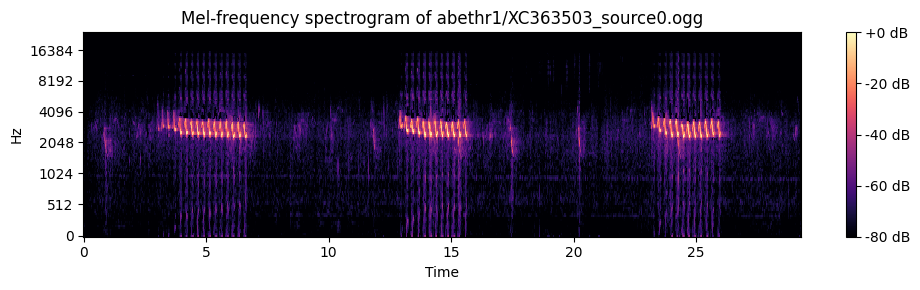

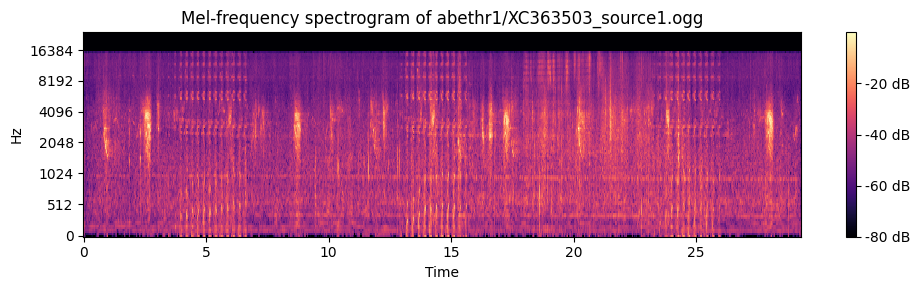

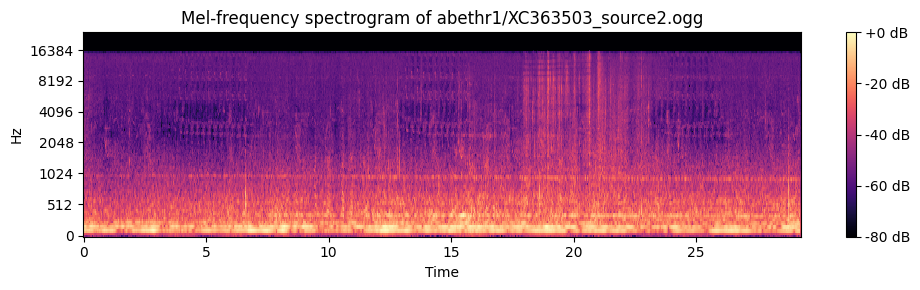

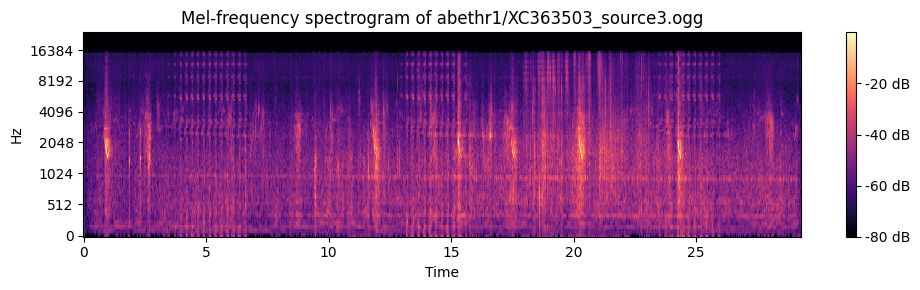

In [12]:
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

sr = 48_000
series = [librosa.load(path, sr=sr)[0] for path in paths]

# plot the spectrograms
for y, path in zip(series, paths):
    plt.figure(figsize=(10, 3))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel-frequency spectrogram of {path.parts[-2]}/{path.parts[-1]}")
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(path))

Lets create top5 and bottom5 predictions for each track

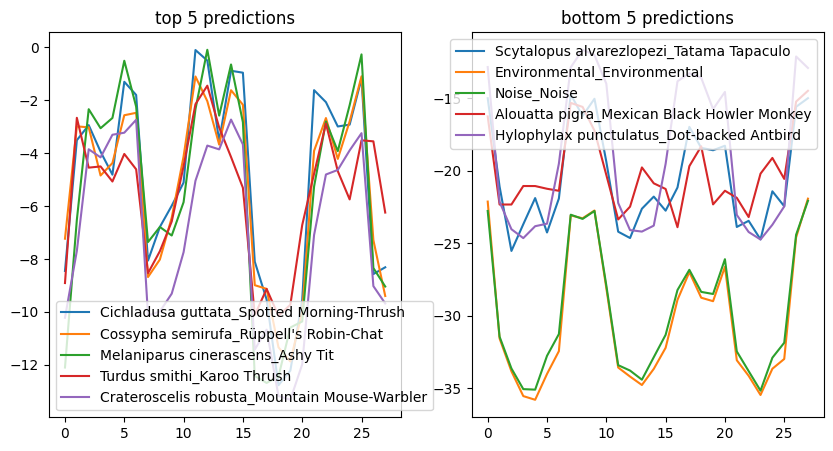

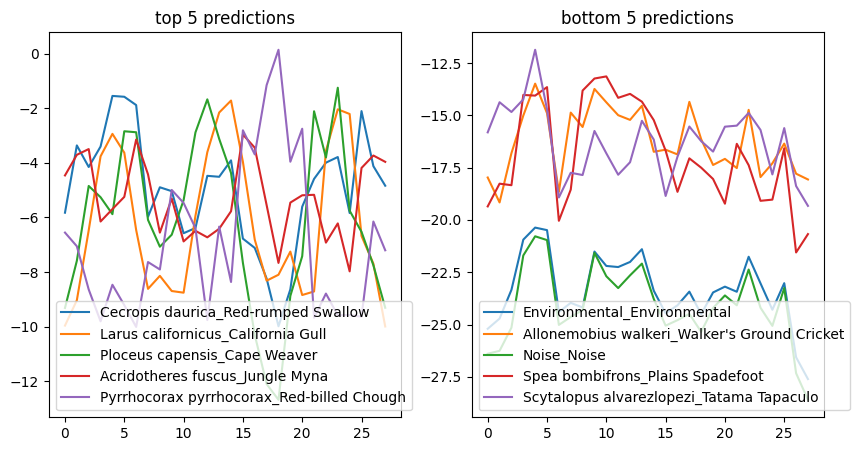

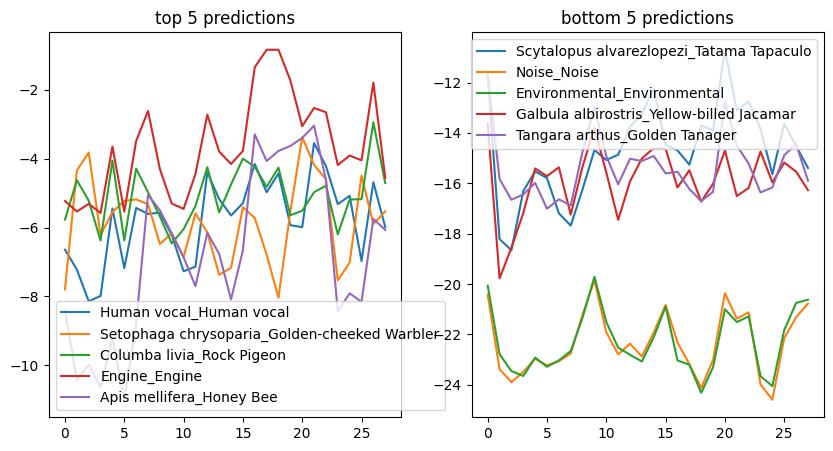

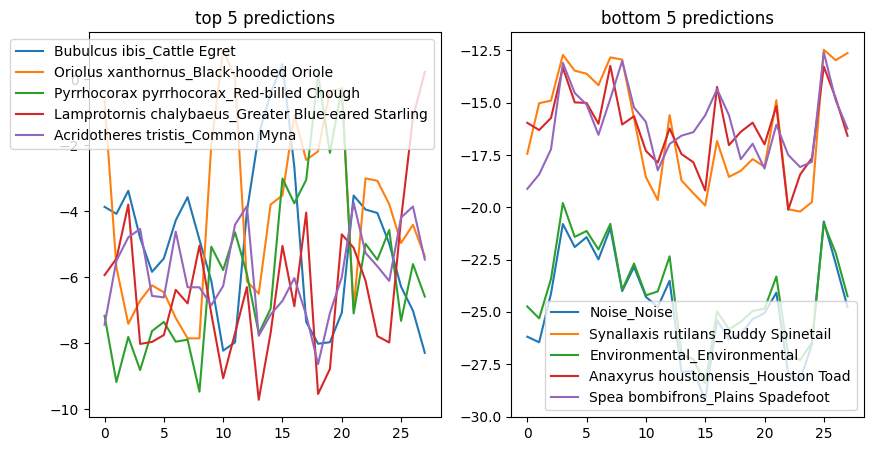

In [16]:
from birdclef.data.utils import slice_seconds

prediction_func = birdnet.prediction_func(model)
labels = birdnet.load_labels(repo_path)

for y, path in zip(series, paths):
    X = slice_seconds(y, sr, seconds=3, step=1)
    pred = prediction_func(X)[0]
    # create a subplot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for idx in birdnet.rank_indices(pred, k=5):
        ax[0].plot(pred[:, idx], label=labels[idx])
        ax[0].set_title("top 5 predictions")
        ax[0].legend()
    for idx in birdnet.rank_indices(-pred, k=5):
        ax[1].plot(pred[:, idx], label=labels[idx])
        ax[1].set_title("bottom 5 predictions")
        ax[1].legend()
    plt.show()